In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from ydata_profiling import ProfileReport
import re

from sklearn.pipeline import Pipeline, make_pipeline

In [7]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm, model_selection,tree, linear_model, neighbors, naive_bayes, ensemble 
from sklearn import discriminant_analysis, gaussian_process

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [2]:
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_features = pd.read_csv('test_set_features.csv')
sub_format = pd.read_csv('submission_format.csv')

In [8]:
train_labels.drop('respondent_id',axis = 1,inplace = True)
frames = [train_features, train_labels]
df = pd.concat(frames, axis=1)

In [9]:
display(df.shape, df.head())

(26707, 38)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [11]:
df.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [12]:
df.drop(['health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

In [13]:
str_cols = df.select_dtypes(include = 'object').columns
df[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


In [14]:
for col in df.columns:
    if df[col].isnull().sum() and df[col].dtypes != 'object':
        df[col].loc[(train_features[col].isnull())] = df[col].mean()
for col in df.columns:
    if df[col].isnull().sum() and df[col].dtypes == 'object':
        df[col].loc[(df[col].isnull())] = df[col].mode().max()

C:\Users\zaida\AppData\Local\Temp\ipykernel_19380\3377083907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[(train_features[col].isnull())] = df[col].mean()
C:\Users\zaida\AppData\Local\Temp\ipykernel_19380\3377083907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[(train_features[col].isnull())] = df[col].mean()
C:\Users\zaida\AppData\Local\Temp\ipykernel_19380\3377083907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [15]:
df.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

In [16]:
le = LabelEncoder()
for col in str_cols:
    df[col] = le.fit_transform(df[col])

In [17]:
df[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,3,1,3,0,2,1,0,1,8,2
1,1,0,3,1,2,1,1,0,1,0
2,0,2,3,1,0,1,0,0,9,0
3,4,0,3,0,2,1,1,1,5,1
4,2,3,3,0,0,0,0,0,9,0


In [18]:
df['cleanliness'] =  df['behavioral_antiviral_meds']+ df['behavioral_avoidance']+\
                        df['behavioral_face_mask']+df['behavioral_wash_hands']+\
                       df['behavioral_large_gatherings'] + df['behavioral_outside_home']+\
                       df['behavioral_touch_face']

In [19]:
print(df[df["h1n1_vaccine"]==1].count()[1])

5674


In [20]:
df['opinion'] = df['opinion_h1n1_vacc_effective'] + df['opinion_h1n1_risk']+\
                  df['opinion_h1n1_sick_from_vacc'] + df['opinion_seas_vacc_effective']+\
                  df['opinion_seas_risk'] + df['opinion_seas_sick_from_vacc']

In [21]:
df['opinion_h1n1'] = df['opinion_h1n1_vacc_effective'] + df['opinion_h1n1_risk']-\
                  df['opinion_h1n1_sick_from_vacc'] 
df['opinion_seasonal'] = df['opinion_seas_vacc_effective']+\
                  df['opinion_seas_risk'] - df['opinion_seas_sick_from_vacc']

In [22]:
df['concern>=2'] = np.where(df['h1n1_concern']>=2,1,0) 
# Since those who have concern>=2 have a pronounced effect on vaccination

df['good_opinion_vacc'] = np.where(df['opinion_seas_vacc_effective'] == 3,1,0)
#If the opinion is 3 it means he/she has a good opinion and is more likely to take the vaccine

df['good_knowledge'] = np.where(df['h1n1_knowledge'] == 2,1,0)
#Same kind of logic as mentioned previously

In [23]:
df['risk'] = np.where(df['opinion_h1n1_risk']>=4,1,0)

#data['sick'] = np.where(data['opinion_h1n1_sick_from_vacc'] == 3,1,0)

### Generating a column combining concern and knowledge, since they have seemingly good correlations!

df['concern_knowledge'] = df['h1n1_concern']+df['h1n1_knowledge']

## square of age group to subtely improve the correlation of that feature with the vaccine probabilty
df['a^2'] = df['age_group']*df['age_group']

In [24]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,3,1,3,0,2,1,0,1,8,2,0.0,0.0,0,0,2.0,11.0,2.0,1.0,0,0,0,0,1.0,9
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,1,0,3,1,2,1,1,0,1,0,0.0,0.0,0,1,4.0,23.0,5.0,2.0,1,0,1,1,5.0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.220312,0.329735,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,2.0,0,2,3,1,0,1,0,0,9,0,2.0,0.0,0,0,1.0,12.0,3.0,3.0,0,0,0,0,2.0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,1.000000,1.0,0.0,0.0,3.0,3.0,5.0,5.0,4.0,1.0,4,0,3,0,2,1,1,1,5,1,0.0,0.0,0,1,3.0,21.0,1.0,8.0,0,0,0,0,2.0,16
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,2,3,3,0,0,0,0,0,9,0,1.0,0.0,0,0,4.0,16.0,4.0,0.0,1,1,0,0,3.0,4


In [25]:
df.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)

Y_label = df[['h1n1_vaccine','seasonal_vaccine']]

In [26]:
df.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[df,Y_label]
data = pd.concat(frames,axis=1)

In [28]:
features = data.columns[:-2]
print(features)
labels = ['h1n1_vaccine', 'seasonal_vaccine']

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')


In [29]:
train,test = train_test_split(data,test_size = 0.2,shuffle = True)
x_train,y_train = train[features],train[labels]
x_test,y_test = test[features],test[labels]

In [30]:
def transform_test(Test_X):
    Test_X.drop(['respondent_id','health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

    # All the NULL values are populated with the mode
            
    d = Test_X
    str_cols = d.select_dtypes(include = 'object').columns

    ### LabelEcoding all categorical types #####
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes != 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes == 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].mode().max()
    le = LabelEncoder()
    for col in str_cols:
        Test_X[col] = le.fit_transform(Test_X[col]) # Converts to int64
            
    data = d
    ### Synthesizing two new features cleanliness level of the individual and opinion of vaccine ####
    data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']
    data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']
    data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                      data['opinion_h1n1_sick_from_vacc'] 
    data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                      data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

    data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0)
    data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0) # 5 before
    data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
    data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)
    data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']
    data['a^2'] = data['age_group']*data['age_group']
    ###### Dropping other features #########
    data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
    Test_X = data
    return Test_X

In [31]:
Test_X = pd.read_csv('test_set_features.csv')
Test_X.shape

(26708, 36)

In [32]:
Test_X = transform_test(Test_X)

C:\Users\zaida\AppData\Local\Temp\ipykernel_19380\3200031253.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
C:\Users\zaida\AppData\Local\Temp\ipykernel_19380\3200031253.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
C:\Users\zaida\AppData\Local\Temp\ipykernel_19380\3200031253.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [33]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data['h1n1_vaccine']

#index through MLA and save performance to table
row_index = 0
data1 = data.copy()
for alg in MLA:
    data = data1
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print('Executing ',MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data[features], data['h1n1_vaccine'], cv  = cv_split)
    #print(cv_results.keys())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions - see section 6 for usage
    alg.fit(data[features], data['h1n1_vaccine'])
    MLA_predict[MLA_name] = alg.predict(data[features])
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

Executing  AdaBoostClassifier
Executing  BaggingClassifier
Executing  ExtraTreesClassifier
Executing  GradientBoostingClassifier
Executing  RandomForestClassifier
Executing  LogisticRegressionCV


c:\Users\zaida\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Executing  PassiveAggressiveClassifier
Executing  RidgeClassifierCV
Executing  SGDClassifier
Executing  Perceptron
Executing  BernoulliNB
Executing  GaussianNB
Executing  KNeighborsClassifier
Executing  LinearSVC


c:\Users\zaida\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number 

Executing  DecisionTreeClassifier
Executing  ExtraTreeClassifier
Executing  LinearDiscriminantAnalysis
Executing  QuadraticDiscriminantAnalysis


c:\Users\zaida\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zaida\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\zaida\anaconda3\lib\site-

Executing  XGBClassifier


,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.836778,0.006144,1.86414
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.83397,0.004322,0.633092
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.832834,0.008616,2.664364
16,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.829365,0.008276,0.073048
7,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.828566,0.00705,0.052185
18,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.828516,0.008477,1.001622
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.827518,0.010406,1.551251
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.822763,0.008802,1.774846
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.814614,0.014844,0.553373
12,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.79864,0.008896,0.009895


Text(0, 0.5, 'Algorithm')

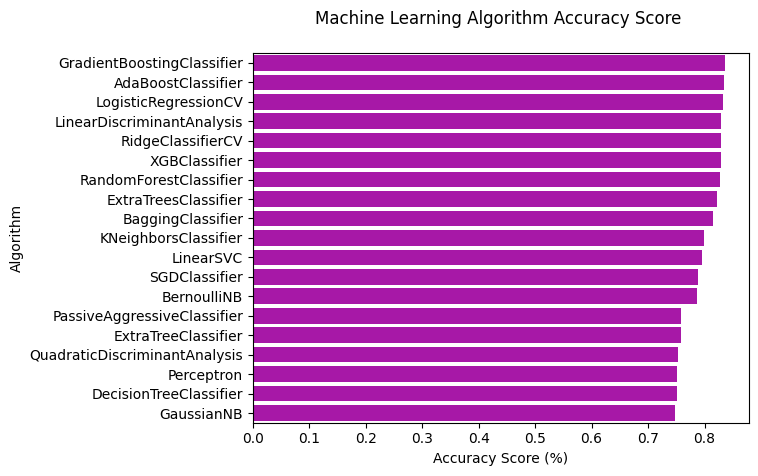

In [34]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [35]:
def find_acc(clf,X,truth,s):
    pred = clf.predict_proba(X.values)
    pred = pred.toarray()
    accuracy = roc_auc_score(truth,pred)
    print(s+" Accuracy is : ",accuracy*100)

In [37]:
from sklearn.model_selection import GridSearchCV
grid_1 = {      "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
RF=RandomForestClassifier()
gs = GridSearchCV(RF, grid_1, n_jobs=-1, cv=2,verbose = True)

In [38]:
clf = BinaryRelevance(classifier=gs, require_dense=[True,True])
clf.fit(x_train,y_train)
find_acc(clf,x_train,y_train,'Training')
find_acc(clf,x_test,y_test,'Cross Validation')

Fitting 2 folds for each of 480 candidates, totalling 960 fits
Fitting 2 folds for each of 480 candidates, totalling 960 fits
Training Accuracy is :  88.22218852627925
Cross Validation Accuracy is :  83.59651468451102


In [41]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200,500]
max_features = ['auto', 'sqrt']
max_depth = [15,20,25]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [42]:
clf = BinaryRelevance(classifier=rf_random, require_dense=[True,True])
clf.fit(x_train,y_train)
find_acc(clf,x_train,y_train,'Training')
find_acc(clf,x_test,y_test,'Cross Validation')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\zaida\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Accuracy is :  95.03432789528556
Cross Validation Accuracy is :  83.01238975816416


In [43]:
def NN_classifier(input_dim,output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25,input_dim=input_dim,activation = 'relu'),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(output_dim,activation = 'softmax')
    ])
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

In [44]:
from sklearn.model_selection import GridSearchCV
param2 = {
            'learning_rate':     [0.01,0.1],
            'max_depth':         [2,3,4],
            'lambda':            [1.0,1.5],
            'subsample':        [0.1,0.2,0.3],
            'colsample_bytree': [0.3,0.5,0.6],
            'min_split_loss' :  [0.01,0.2],
            'min_split_size' : [2,4,6]
        }
classifier = XGBClassifier(feature_names = features,verbose = False)
xgb = GridSearchCV(classifier, param2, n_jobs=-1, cv=2,verbose = True)

In [46]:
clf = BinaryRelevance(classifier=xgb, require_dense=[True,True])
clf.fit(x_train,y_train)
find_acc(clf,x_train,y_train,'Training')
find_acc(clf,x_test,y_test,'Cross Validation')

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[02:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[02:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.

Training Accuracy is :  86.1418225600605
Cross Validation Accuracy is :  83.56803814022376


In [47]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200]
max_features = ['auto', 'sqrt']
max_depth = [2,3,7,5,15,20,25]
max_depth.append(None)
min_samples_split = [0.2,0.3,0.6,1.2,1.5,2.0,3.0,4.0]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = XGBClassifier(feature_names = features,verbose = False)
etc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [48]:
clf = BinaryRelevance(classifier=etc, require_dense=[True,True])
clf.fit(x_train,y_train)
find_acc(clf,x_train,y_train,'Training')
find_acc(clf,x_test,y_test,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[02:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[02:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

Training Accuracy is :  86.48762805894798
Cross Validation Accuracy is :  83.40166940612794


In [49]:
cb_hps = {  
            'depth':              [2,3,4,5,7],
            'l2_leaf_reg':        [2,3,5,10],
            'random_seed':        [5,8,10],
            'colsample_bylevel': [0.3,0.5,0.6],
            'n_estimators':      [100,200]
        }

cb = CatBoostClassifier()
cbt = RandomizedSearchCV(estimator = cb, param_distributions = cb_hps, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [50]:
clf = BinaryRelevance(classifier=cbt, require_dense=[True,True])
clf.fit(x_train,y_train)
find_acc(clf,x_train,y_train,'Training')
find_acc(clf,x_test,y_test,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits


c:\Users\zaida\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
7 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zaida\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\zaida\anaconda3\lib\site-packages\catboost\core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\zaida\anaconda3\lib\site-packages\catboost\core.py", line 2357, in 

0:	learn: 0.6729021	total: 156ms	remaining: 31.1s
1:	learn: 0.6525380	total: 166ms	remaining: 16.4s
2:	learn: 0.6343619	total: 176ms	remaining: 11.6s
3:	learn: 0.6172376	total: 186ms	remaining: 9.12s
4:	learn: 0.6014284	total: 196ms	remaining: 7.65s
5:	learn: 0.5865472	total: 207ms	remaining: 6.7s
6:	learn: 0.5730163	total: 218ms	remaining: 6s
7:	learn: 0.5600835	total: 228ms	remaining: 5.47s
8:	learn: 0.5473839	total: 240ms	remaining: 5.1s
9:	learn: 0.5362531	total: 253ms	remaining: 4.8s
10:	learn: 0.5262788	total: 263ms	remaining: 4.52s
11:	learn: 0.5164546	total: 274ms	remaining: 4.3s
12:	learn: 0.5071562	total: 286ms	remaining: 4.12s
13:	learn: 0.4994334	total: 298ms	remaining: 3.96s
14:	learn: 0.4916756	total: 309ms	remaining: 3.81s
15:	learn: 0.4862753	total: 320ms	remaining: 3.67s
16:	learn: 0.4804789	total: 327ms	remaining: 3.52s
17:	learn: 0.4746878	total: 338ms	remaining: 3.42s
18:	learn: 0.4687787	total: 347ms	remaining: 3.31s
19:	learn: 0.4635559	total: 360ms	remaining: 3.2

In [51]:
classifier = CatBoostClassifier(
n_estimators = 300,depth = 5,l2_leaf_reg =0.5,
                                random_seed = 2,colsample_bylevel = 0.9,verbose = False)

In [52]:
clf = BinaryRelevance(classifier=classifier, require_dense=[True,True])
clf.fit(x_train,y_train)
find_acc(clf,x_train,y_train,'Training')
find_acc(clf,x_test,y_test,'Cross Validation')

Training Accuracy is :  86.00514429963677
Cross Validation Accuracy is :  83.80170303862877


In [53]:
submission = clf.predict_proba(Test_X.values)
submission_df = pd.DataFrame.sparse.from_spmatrix(submission)

In [54]:
trial = submission_df
trial['respondent_id'] = trial.index+26707 # Converting the default indices
trial['h1n1_vaccine'] = trial[0].astype('float64') # Data required to be in float64 
trial['seasonal_vaccine'] = trial[1].astype('float64')
trial.set_index('respondent_id') # Make index as respondent_id
trial.drop([0,1],axis=1,inplace=True) # Drop old index axis
submission_df = trial 

In [55]:
submission_df

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.107841,0.191130
1,26708,0.042384,0.046619
2,26709,0.360907,0.709009
3,26710,0.507392,0.891375
4,26711,0.393687,0.638935
...,...,...,...
26703,53410,0.262672,0.425711
26704,53411,0.179365,0.368788
26705,53412,0.131889,0.162011
26706,53413,0.075921,0.364903


In [56]:
submission_df.to_csv('Submission.csv',index = False)